# CW 2 Task 3 (Mastery component)

*This Task is only for MSc and MSci students.*

We are interested in finding communities in the karate club network using modularity maximistion with spectral partitioning. You should be able to re-use some of the code that is available in the realted coding tasks.

We want you to:
1. Find the spectral partition of the network (using the normalised Laplacian).
2. Calculate the modularity of the spectral partition.
3. Then we want to partition further by looking at each subgraph (defined as a community). We take the first sub-graph and compute its spectral partition. Combining this split with the original partition, does the modularity increase or decrease? If it increases then keep this partition. Do this for each subgraph.
4. Stop when further partitions don't improve the modularity.

In [1]:
# import necessary packages
import networkx as nx
import numpy as np
from scipy.sparse import linalg
import matplotlib.pyplot as plt
import scipy as sp
import itertools
import pandas as pd

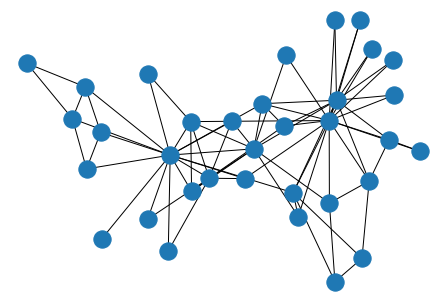

In [2]:
# call the karate club graph
g = nx.karate_club_graph()

# plot the graph
pos = nx.spring_layout(g)
nx.draw(g, pos=pos)

# return the adjacency matrix as a NumPy array
A = nx.to_numpy_array(g)

In [60]:
def get_subgraph(A, nodes):
    """ get the subgraph based on a list of nodes """
    A_subgraph = A[np.ix_(nodes,nodes)] 
    return A_subgraph

def get_laplacian(A):
    """ Get Laplacian of my network """
    n = len(A)
    D_1 = np.diag(1/(A@np.ones(n)))
    return np.identity(n) - A @ D_1 

def get_spectral_partition(A):
    """ Compute spectral partition with Laplacian """
    n = len(A)
    spectral_partition = np.zeros(n)
    L = get_laplacian(A)
    eigenvals, eigenvecs = sp.linalg.eigh(L,eigvals=(1,1))
    spectral_partition[eigenvecs[:,0]>0] = 1
    return spectral_partition 

def get_modularity(A, partition):
    """ Compute the Modularity of partition with network """
    n = len(A)
    v = partition.reshape(n,1)
    d = (A@np.ones(n)).reshape(n,1)
    E = (1/2) * np.sum(d)
    R = (1/(2*E)) * (d@ d.T)
    H = np.concatenate([(v==k)*1 for k in np.unique(v)],axis=1)
    Q = (1/(2*E)) * np.trace((H.T)@ (A - R) @ H)
    return Q 

def set_new_partition(possible_partition, sub_partition, idx_nodes, comm_id):   
    """ Combine original partition with new subgraph partition """
    sub_partition[sub_partition==0] = comm_id
    sub_partition[sub_partition==1] = comm_id+1   
    possible_partition[idx_nodes] = sub_partition
    return possible_partition 

In [72]:
increasing_q = True

# initial spectral partition
partition = get_spectral_partition(A)
Q = get_modularity(A, partition)
print('Initial Q:', Q)
comm_id = 0

# loop over until modularity doesn't increase further
while increasing_q:
    
    # define the original modularity
    Q_orig = Q
    
    # finding unique communities in partition
    unique_comms = np.unique(partition)   
    
    # loop over each community in the partition
    for comm in unique_comms:
        
        # make a copy of best partition so far  
        possible_partition = partition.copy()
        
        # find index of all nodes in community
        idx_nodes = np.where(partition==comm)[0]
        
        # get subgraph of graph
        A_sub = get_subgraph(A, idx_nodes)  
        
        # compute spectral partition of subgraph
        sub_partition = get_spectral_partition(A_sub)
        
        
        # iterating comm id
        comm_id += 2
        
        # define new partition
        possible_partition = set_new_partition(possible_partition, sub_partition, idx_nodes, comm_id)
        
        # compute modularity of new possible partition
        Q_new = get_modularity(A, possible_partition)  ## <-- EDIT THIS LINE
        
        # if the partition of subgraph improved modularity then keep it
        if Q_new>Q:
            partition = possible_partition.copy()
            print('New Q: {}, Partition: {}'.format(Q_new, partition))
            Q = Q_new
            
    # break out of the while loop if modularity isn't increasing
    if not Q>Q_orig: 
        increasing_q = False
        
print('------------------')        
print('Optimal number of clusters: {}'.format(np.unique(partition).shape[0]))

Initial Q: 0.1261505588428666
New Q: 0.22181130834976986, Partition: [4. 4. 4. 4. 4. 4. 4. 4. 0. 5. 4. 4. 4. 5. 0. 0. 4. 4. 0. 5. 0. 4. 0. 4.
 4. 4. 5. 4. 4. 5. 0. 4. 0. 5.]
New Q: 0.27827087442472054, Partition: [8. 8. 8. 8. 8. 8. 8. 8. 0. 5. 8. 8. 8. 5. 0. 0. 8. 8. 0. 5. 0. 8. 0. 9.
 9. 9. 5. 9. 8. 5. 0. 8. 0. 5.]
New Q: 0.3071992110453649, Partition: [16. 16. 16. 16. 17. 17. 17. 16.  0.  5. 17. 16. 16.  5.  0.  0. 17. 16.
  0.  5.  0. 16.  0.  9.  9.  9.  5.  9. 16.  5.  0. 16.  0.  5.]
New Q: 0.3200197238658778, Partition: [27. 27. 27. 27. 17. 17. 17. 27.  0.  5. 17. 27. 27.  5.  0.  0. 17. 27.
  0.  5.  0. 27.  0.  9.  9.  9.  5.  9. 26.  5.  0. 26.  0.  5.]
------------------
Optimal number of clusters: 6
